In [1]:
import MIMENet
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

In [2]:
#set path to simulation data
simulation_path = "../data/simulation_data/experimental_conditions"

In [3]:
#set training parameters
training_path = "../data/simulation_data/second_round/parsed_reads.txt"
epochs = 30
learning_rate = 0.00001
batch_size = 2**11
lambda_l1 = 0.00001
hidden_size_factor = 2
bottleneck = 1/2

In [4]:
model, history = MIMENet.train(training_path, epochs, learning_rate, batch_size, lambda_l1, hidden_size_factor, bottleneck, simulation_path+'/secondFromProt1/prot1/single_kds.txt')

Device: cuda:0


100%|██████████| 30/30 [02:01<00:00,  4.03s/it]


In [5]:
#save model
torch.save(model.state_dict(), './modelExpCond.pth')

In [6]:
#save training history as json
with open('./history_exp.json', 'w') as f:
    json.dump(history, f)

In [4]:
#load saved model, training history, and prediction history
input_size = len(open(training_path).readline().split('_')[0])
model = MIMENet.MIMENet(input_size, hidden_size_factor, bottleneck, 1)
model.load_state_dict(torch.load('./modelExpCond.pth'))
#puto model to gpu
model.to('cuda:0')
#put model in eval mode
model.eval()
#load history
with open('./history_exp.json', 'r') as f:
    history = json.load(f)

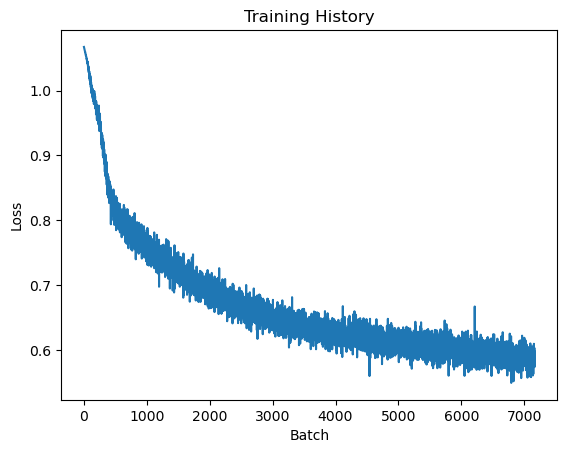

In [5]:
#plot training history
plt.plot(history['training'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Batch")
#limit x axis
#plt.xlim(0, 1000)
plt.show()

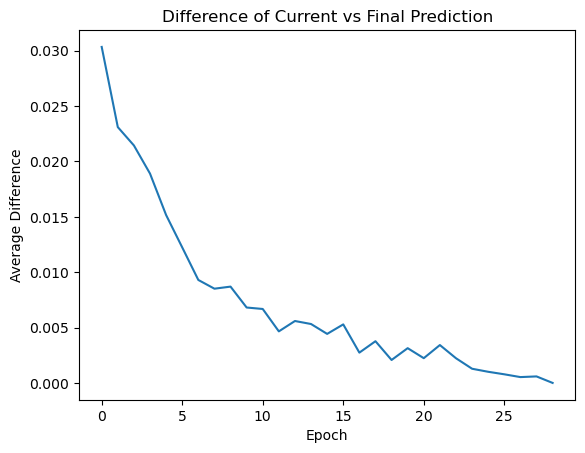

In [6]:
#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
plt.plot(difference)
plt.title("Difference of Current vs Final Prediction")
plt.ylabel("Average Difference")
plt.xlabel("Epoch")
plt.show()

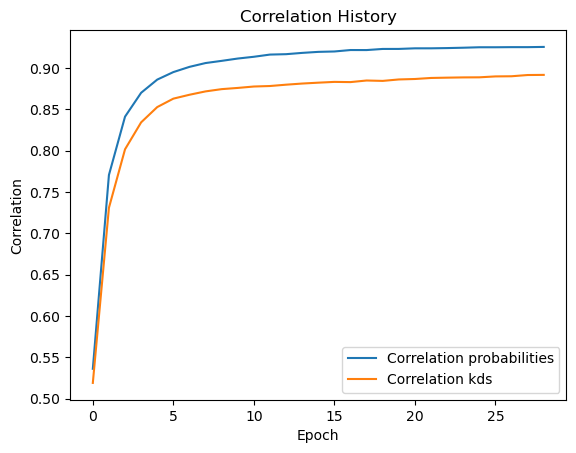

In [7]:
#plot correlation history rows as lines
plt.plot(history['correlation_probs'][1:], label='Correlation probabilities')
plt.plot(history['correlation_kds'][1:], label='Correlation kds')
plt.legend()
plt.title("Correlation History")
plt.ylabel("Correlation")
plt.xlabel("Epoch")
plt.show()

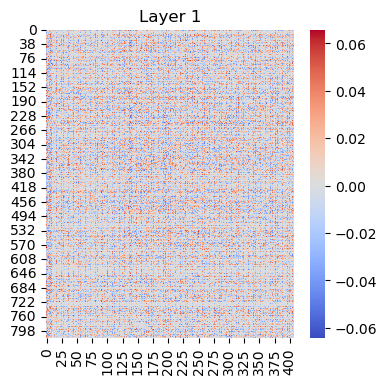

max weight value:  0.06577975
min weight value:  -0.06415354
number of pruned weights:  74771
number of non zero weights:  258157
max bias value:  0.05935343
min bias value:  -0.04863294
number of pruned biases:  21
number of non zero biases:  795


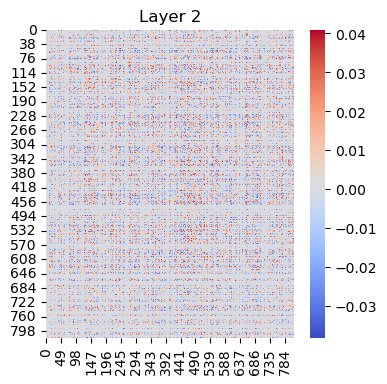

max weight value:  0.04097866
min weight value:  -0.038107127
number of pruned weights:  316489
number of non zero weights:  349367
max bias value:  0.04421216
min bias value:  -0.029924769
number of pruned biases:  173
number of non zero biases:  643


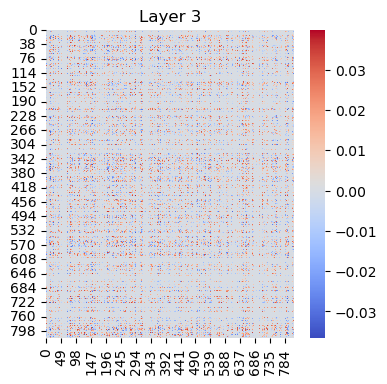

max weight value:  0.039929688
min weight value:  -0.036492813
number of pruned weights:  474732
number of non zero weights:  191124
max bias value:  0.043887198
min bias value:  -0.030870965
number of pruned biases:  238
number of non zero biases:  578


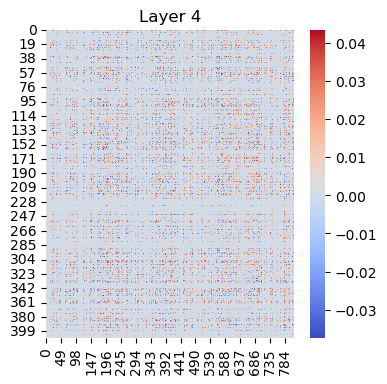

max weight value:  0.043427303
min weight value:  -0.037305288
number of pruned weights:  239204
number of non zero weights:  93724
max bias value:  0.036869407
min bias value:  -0.027656712
number of pruned biases:  118
number of non zero biases:  290


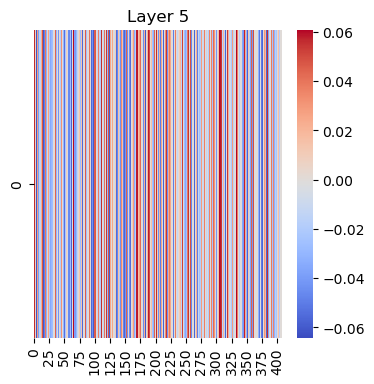

max weight value:  0.06096481
min weight value:  -0.06417922
number of pruned weights:  98
number of non zero weights:  310
max bias value:  -6.697558e-05
min bias value:  -6.697558e-05
number of pruned biases:  0
number of non zero biases:  1


In [8]:
for name, param in model.named_parameters():
    #if weight is not a bias
    if 'bias' not in name:
        #reshape weights to 2d array
        weight = param.data.cpu().numpy().reshape(param.data.cpu().numpy().shape[0], param.data.cpu().numpy().shape[1])
        #plot heatmap of weights
        plt.figure(figsize=(4,4))
        sns.heatmap(weight, cmap='coolwarm')
        # get layer number from name
        layer = [int(s) for s in name if s.isdigit()]
        plt.title(f'Layer {layer[0]}')
        plt.show()

        print('max weight value: ', np.max(weight))
        print('min weight value: ', np.min(weight))
        print('number of pruned weights: ', np.sum(weight == 0))
        print('number of non zero weights: ', np.sum(weight != 0))

    else:
        bias = param.data.cpu().numpy()
 
        print('max bias value: ', np.max(bias))
        print('min bias value: ', np.min(bias))
        print('number of pruned biases: ', np.sum(bias == 0))
        print('number of non zero biases: ', np.sum(bias != 0))

In [9]:
#get percent of parameters pruned
total_params = 0
pruned_params = 0
for param in model.parameters():
    total_params += param.numel()
    pruned_params += np.sum(param.data.cpu().numpy() == 0)
print('percent of parameters pruned: ', pruned_params/total_params)

percent of parameters pruned:  0.5526918038636908


In [10]:
# read in kd values
single_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')

#insert 1 at position 0 and then every 3rd position
single_kd_sim = np.insert(single_kd_sim, 0, 1)
single_kd_sim = np.insert(single_kd_sim, np.arange(4, len(single_kd_sim), 3), 1)
single_kd_sim[0:10]

array([1.      , 0.212905, 0.362492, 1.      , 1.      , 0.393369,
       3.48016 , 1.      , 1.      , 1.      ])

In [11]:
single_prob_pred = MIMENet.inferSingleProbabilities(model, input_size)

Text(0.8, 0.1, 'r = 0.93')

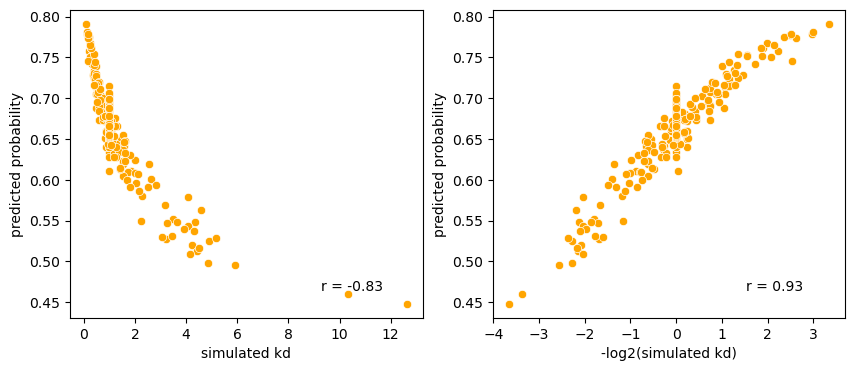

In [12]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot single_kd_sim vs single_kd_pred
sns.scatterplot(x=single_kd_sim, y=single_prob_pred, color='orange', ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(single_kd_sim, single_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)

# -log2(single_kd_sim) vs single_prob_pred
sns.scatterplot(x=-np.log2(single_kd_sim), y=single_prob_pred, color='orange', ax=ax2)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(-np.log2(single_kd_sim), single_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

Text(0, 0.5, 'z score')

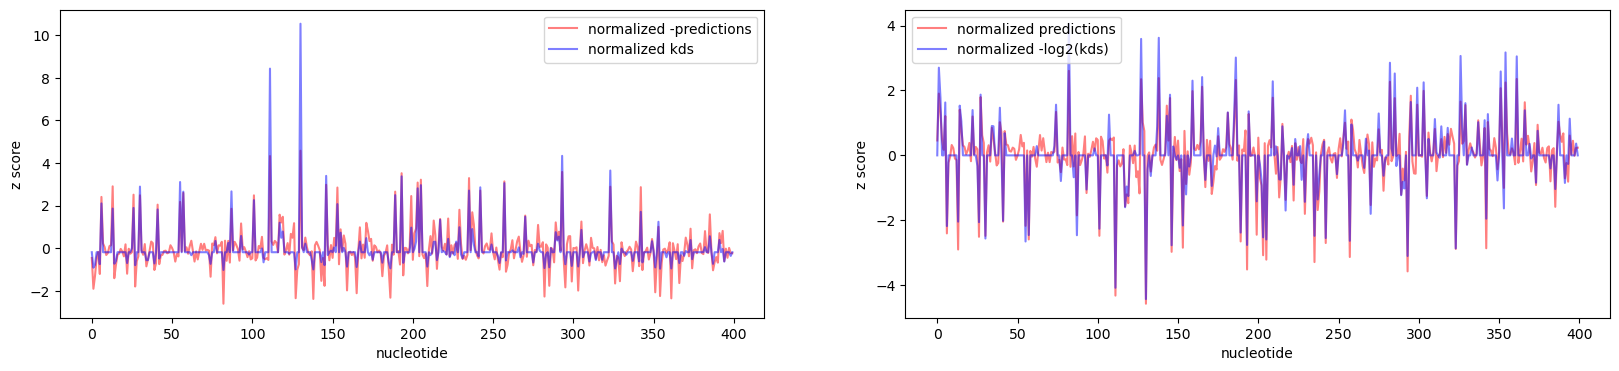

In [13]:
#z score predictions
single_prob_pred_normalized = (single_prob_pred - np.mean(single_prob_pred))/np.std(single_prob_pred)

#z score kds
single_kd_sim_normalized = (single_kd_sim - np.mean(single_kd_sim))/np.std(single_kd_sim)

# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

#lineplot of normalized z score predictions vs kds
# add to first plot
sns.lineplot(x=np.arange(0, len(single_prob_pred_normalized)), y=-single_prob_pred_normalized, label='normalized -predictions', color='red', alpha=0.5, ax=ax1)
sns.lineplot(x=np.arange(0, len(single_kd_sim_normalized)), y=single_kd_sim_normalized, label='normalized kds', color='blue', alpha=0.5, ax=ax1)
ax1.set_xlabel('nucleotide')
ax1.set_ylabel('z score')

# z score -log2(kds)
single_kd_sim_log_normalized = (-np.log2(single_kd_sim) - np.mean(-np.log2(single_kd_sim)))/np.std(-np.log2(single_kd_sim))

# lineplot of normalized z score predictions vs -log2(kds)
sns.lineplot(x=np.arange(0, len(single_prob_pred_normalized)), y=single_prob_pred_normalized, label='normalized predictions', color='red', alpha=0.5, ax=ax2)
sns.lineplot(x=np.arange(0, len(single_kd_sim_log_normalized)), y=single_kd_sim_log_normalized, label='normalized -log2(kds)', color='blue', alpha=0.5, ax=ax2)
plt.xlabel('nucleotide')
plt.ylabel('z score')


(0.0, 1.0)

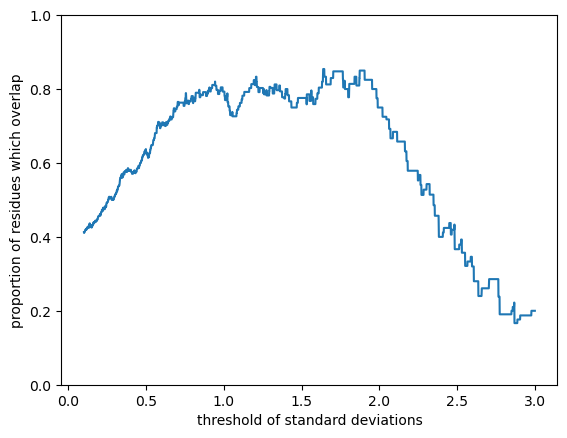

In [14]:
#check overlap of normalized predictions and normalized -log(kds) for absolute value greater than 0.5
#loop over threshold values
overlapProportions = []
for threshold in np.arange(0.1, 3, 0.001):
    #get indices of scaled predictions and scaled -log(kds) that are greater than the threshold
    indices = np.where(np.abs(single_prob_pred_normalized) > threshold)[0]
    indices2 = np.where(np.abs(single_kd_sim_log_normalized) > threshold)[0]
    #get the intersection of the two sets of indices
    overlap = np.intersect1d(indices, indices2)
    #get the proportion of the intersection to the union of the two sets of indices
    overlapProportions.append(len(overlap)/len(np.union1d(indices, indices2)))

#plot overlapProportions
sns.lineplot(x=np.arange(0.1, 3, 0.001), y=overlapProportions)
plt.xlabel('threshold of standard deviations')
plt.ylabel('proportion of residues which overlap')
plt.ylim(0, 1)

In [15]:
# read in kd values
single_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')
#predict kds
single_kd_pred = MIMENet.inferSingleKds(model, input_size)

100%|██████████| 100/100 [00:00<00:00, 430.96it/s]


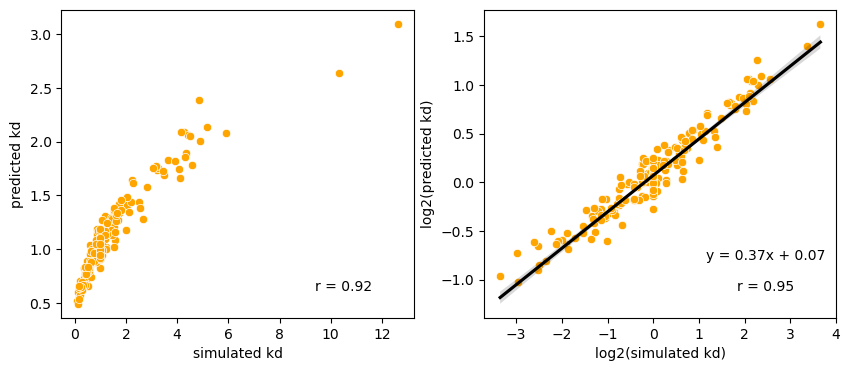

In [16]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot single_kd_sim vs single_kd_pred
sns.scatterplot(x=single_kd_sim, y=single_kd_pred, color='orange', ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(single_kd_sim, single_kd_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)

# log2(single_kd_sim) vs log2(single_kd_pred)
sns.scatterplot(x=np.log2(single_kd_sim), y=np.log2(single_kd_pred), color='orange', ax=ax2)
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(single_kd_sim), np.log2(single_kd_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(single_kd_sim), y=np.log2(single_kd_pred), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(single_kd_sim), np.log2(single_kd_pred), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(single_kd_sim), np.log2(single_kd_pred), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()


In [17]:
#load pairwise kd values
pair_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_kds.txt')

#predict pairwise probabilities
pair_prob_pred = MIMENet.inferPairwiseProbabilities(model, input_size)

#predict pairwise kds
pair_kd_pred = MIMENet.inferPairwiseKds(model, input_size)

100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


Text(0.8, 0.1, 'r = 0.91')

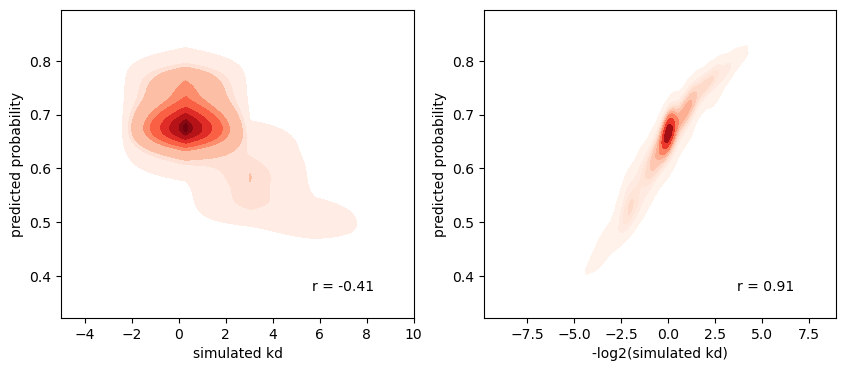

In [18]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_prob_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
sns.kdeplot(x=-np.log2(pair_kd_sim), y=pair_prob_pred, cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(-np.log2(pair_kd_sim), pair_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

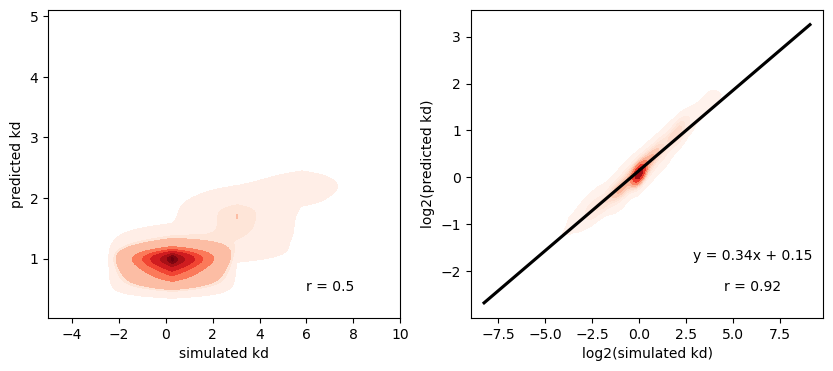

In [19]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_kd_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
sns.kdeplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred), cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [20]:
#load pairwise epistasis values
pair_epistasis_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_epistasis.txt')

#predict pairwise epistasis
pair_epistasis_pred = MIMENet.inferEpistasis(model, input_size)

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Text(0.8, 0.1, 'r = 0.01')

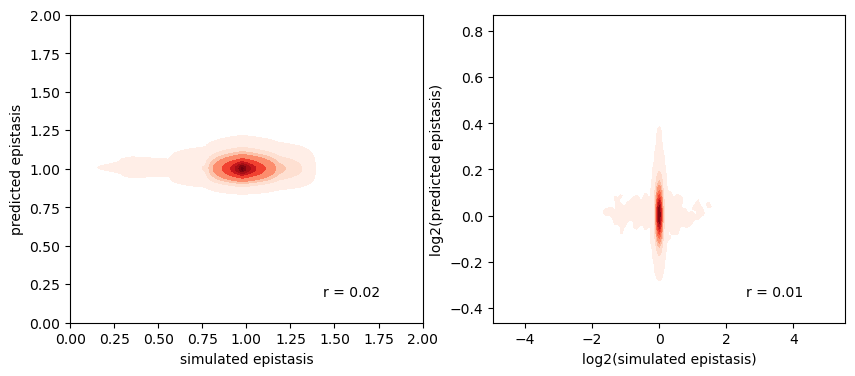

In [24]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_epistasis_sim vs pair_epistasis_pred as kde plot
sns.kdeplot(x=pair_epistasis_sim, y=pair_epistasis_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated epistasis')
ax1.set_ylabel('predicted epistasis')
#set x limit
ax1.set_xlim(0, 2)
#set y limit
ax1.set_ylim(0, 2)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_epistasis_sim, pair_epistasis_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_epistasis_sim) vs log2(pair_epistasis_pred) as kde plot
sns.kdeplot(x=np.log2(pair_epistasis_sim), y=np.log2(pair_epistasis_pred), cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('log2(simulated epistasis)')
ax2.set_ylabel('log2(predicted epistasis)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_epistasis_sim), np.log2(pair_epistasis_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)